<a href="https://colab.research.google.com/github/tanatiem/BADS7105-CRM-Analytics/blob/main/Homework%2011%20-%20Voice%20of%20Customers/hw11-voice-of-customers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 11 - Voice of Customers
**Subject:** BADS 7205 - CRM Analytics and Intelligence  
**Student:** Tanat Iempreedee (6210422036)

## **Initialization**

In [ ]:
!pip install --upgrade pythainlp
!pip install pyLDAvis
!pip install sefr_cut
# !pip install deepcut
# !pip install tensorflow_text

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

import pandas as pd
import numpy as np
import re
import string
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


import pythainlp
from pythainlp.tokenize import sent_tokenize, word_tokenize
import gensim

import sefr_cut
sefr_cut.load_model(engine='tl-deepcut-ws1000')
# sefr_cut.load_model(engine='ws1000')


# import tensorflow_hub as hub
# import tensorflow_text
# import tensorflow as tf

import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()


In [ ]:
%cd "/content/drive/My Drive/BADS/7105 CRM/work/11 - Voice of customers"

/content/drive/My Drive/BADS/7105 CRM/work/11 - Voice of customers


In [ ]:
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('/content/drive/MyDrive/fonts/K2D-Regular.ttf')
mpl.rc('font', family='K2D', size=12, weight=200)

## **Load dataset**

In [ ]:
df = pd.read_csv('CustomerReviews.csv')
df.tail()

,Review ID,Restaurant_ID,Restaurant,User,Headline,Review,Rating
16,17,436045MJ-ข้าน้อยขอชาบู,ข้าน้อยขอชาบู,ployynp,บุฟเฟ่ต์ชาบูและพิซซ่าไม่อั้นในราคา 199 บาท เน้...,หลังจากที่เคยลองสาขายูเนี่ยนมอลล์ไป รอบนี้มาที...,4.0
17,18,436045MJ-ข้าน้อยขอชาบู,ข้าน้อยขอชาบู,27a91236fe5e4559a4f097c97a480781,ร้านบุฟเฟ่ต์ ราคามิตรภาพ อยู่ชั้น4 ติดโรงหนัง ...,ร้านบุฟเฟ่ต์ที่มีโปรโมชั่นหัวละ199บาท ไม่รวมน้...,4.0
18,19,436045MJ-ข้าน้อยขอชาบู,ข้าน้อยขอชาบู,0b81d251e4db486f9bcdba73b374ed99,ของหลากหลาย ปนๆ งงๆ นิดหน่อย,เคยรู้จักร้านนี้จากที่ union mall ไม่เคยได้ลอง...,3.0
19,20,436045MJ-ข้าน้อยขอชาบู,ข้าน้อยขอชาบู,40e0e087f3914fd49a8933b5a29936ca,อร่อยมากค่ะ คุ้มค่าสมราคา บุฟเฟ่หมูผักต่างๆ รว...,อร่อยมากค่ะ คุ้มค่าสมราคา บุฟเฟ่หมูผักต่างๆ รว...,5.0
20,21,436045MJ-ข้าน้อยขอชาบู,ข้าน้อยขอชาบู,41841cb99ea243a3a8d4b006e946c586,แม้จะแปลกบ้าง แต่ก็ถือว่าอยู่ในเกณฑ์ที่ดี มีอา...,ก็ตามที่เขียนเลยครับ ว่า ถ้าจะจ่ายในราคา 199 บ...,NaN


##**Text preprocessing**

In [ ]:
# some fixing of words to help with word tokenization
correction_dict = {
    'โมโม่' : 'momo', 'มากก' : 'มาก', 'กกก' : 'ก', 'แวท' : 'vat', 'พิซเซอเรีย' : 'pizzeria', 'พิซซ่า' : 'pizza', 
    'เก้บ' : 'เก็บ', 'ชูชิ' : 'ซูชิ', 'ซึป' : 'ซุป', 'ชาบูชิ' : 'shabushi', 'อารามณ์' : 'อารมณ์', 'ส่งน' : 'ส่วน', 'สไลต์' : 'สไลด์', 'ประยุคก์' : 'ประยุกต์',
    'ไอติม' : 'icecream', 'พาราไดส์' : 'paradise', 'พาราไดซ์' : 'paradise', 'อัพเดท' : 'update', 'นาราย' : 'narai ', 'พรีเมี่ยม' : 'พรีเมียม',
    'บ๋วย' : 'บ๊วย', 'เฟรนไชส์' : 'แฟรนไชส์'
}

# text cleansing
def cleanse_text(text):

    text = text.strip().lower()

    for old,new in correction_dict.items():
        text = text.replace(old, new)

    # remove empty spaces
    text = re.sub(r'\u200b', '', text)

    # replace punctuations with a space
    text = re.sub(r'[ๆฯ!#$&%\"\'()*+,-./:;<=>?@\[\]\\^_`{}|~]',' ', text)

    # replace numbers with a space
    text = re.sub(r'\d',' ', text)

    # replace whitespaces with a space
    # text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleansed_text'] = df.apply(lambda x: cleanse_text(x['Headline'] + ' ' + x['Review']), axis=1)

# sentence & word tokenization
df['tokens'] = df['cleansed_text'].apply(lambda x: [ w for st in sent_tokenize(x, engine='whitespace+newline') for w in sefr_cut.tokenize(st,k=100)])

# flatten & remove stop words
stopwords = list(pythainlp.corpus.thai_stopwords()) 
removed_words = ['ร้าน','บาท','สำหรับ','ชื่อ','ทาน','ดี','กิน','อาหาร','ดู','คน','ตัว','ลอง','ตอน','เลือก','ใจ']
screening_words = stopwords + removed_words

df['tokens'] = df['tokens'].apply(lambda x: [ w for sublist in x for w in sublist if w not in screening_words])

# replace after tokenization
replace_dict = {
    'บุพเฟ่' : 'บุฟเฟ่ต์',
    'บุฟเฟ่' : 'บุฟเฟ่ต์',
    'บุฟเฟ' : 'บุฟเฟ่ต์',
    'บุฟเฟต' : 'บุฟเฟ่ต์',
    'รสชาต' : 'รสชาติ', 
}
df['tokens'] = df['tokens'].apply(lambda x: [ replace_dict.get(w) if w in replace_dict else w for w in x ])
df.loc[:5, 'tokens']

0    [บริการ, พนักงาน, น่ารัก, สะอาด, สะอ้าน, ใส่, ...
1    [รสชาติ, เหมือน, สาขา, สาขา, บริการ, นั่ง, นึก...
2    [ชาบูพรีเมียม, สไตล์, ญี่ปุ่น, เนื้อ, มากก, นั...
3    [เนื้อ, icecream, คุ้ม, ค่า, นึก, ชาบู, เนื้อ,...
4    [ภาพ, บริการ, เดิน, หน้า, กลิ่น, ชาบูหอม, โปรบ...
5    [อิ่ม, momo, บุฟเฟ่ต์, ชา, บู, แนว, ญี่ปุ่น, ส...
Name: tokens, dtype: object

In [ ]:
data_words = df['tokens']
min_count = 1
threshold = 1

bigram = gensim.models.Phrases(data_words, min_count=min_count, threshold=threshold)
trigram = gensim.models.Phrases(bigram[data_words], min_count=min_count, threshold=threshold)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# trigram_mod[data_words[3]]
df['trigram_mod'] = trigram_mod[data_words]
df.head()

,Review ID,Restaurant_ID,Restaurant,User,Headline,Review,Rating,cleansed_text,tokens,trigram_mod,topic,score
0,1,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,7b16469831074f7abc7824745ee75212,ที่สำคัญของร้านนี้คือบริการดีมากพนักงานน่ารักส...,ที่สำคัญของร้านนี้คือบริการดีมากพนักงานน่ารักส...,5.0,ที่สำคัญของร้านนี้คือบริการดีมากพนักงานน่ารักส...,"[บริการ, พนักงาน, น่ารัก, สะอาด, สะอ้าน, ใส่, ...","[บริการ_พนักงาน, น่ารัก, สะอาด, สะอ้าน, ใส่, ป...",2,0.998289
1,2,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,pakkaramonpondej,รสชาติเหมือนทุกสาขา แต่สาขานี้ บริการดี ที่นั่งดี,นึกถึงชาบูญี่ปุ่นยังไงก็ต้อง คิดถึงโมโม่ พาราไ...,5.0,รสชาติเหมือนทุกสาขา แต่สาขานี้ บริการดี ที่นั่...,"[รสชาติ, เหมือน, สาขา, สาขา, บริการ, นั่ง, นึก...","[รสชาติ, เหมือน_สาขา, สาขา, บริการ, นั่ง, นึก,...",3,0.997637
2,3,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,saanowy,ชาบูพรีเมี่ยมสไตล์ญี่ปุ่น เนื้อดีมากกก,มาทานช่วงนี้ สามารถนั่งโต๊ะเดียวกัน หม้อเดียวก...,4.0,ชาบูพรีเมียมสไตล์ญี่ปุ่น เนื้อดีมากก มาทานช่วง...,"[ชาบูพรีเมียม, สไตล์, ญี่ปุ่น, เนื้อ, มากก, นั...","[ชาบูพรีเมียม, สไตล์, ญี่ปุ่น, เนื้อ, มากก, นั...",0,0.999251
3,4,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,ployynp,เนื้อดี ไอติมดี คุ้มค่าดี,ถ้านึกถึงชาบูที่มีเนื้อเน้นๆ ในราคาไม่โหดจนเกิ...,4.0,เนื้อดี icecreamดี คุ้มค่าดี ถ้านึกถึงชาบูที่ม...,"[เนื้อ, icecream, คุ้ม, ค่า, นึก, ชาบู, เนื้อ,...","[เนื้อ, icecream, คุ้ม_ค่า, นึก_ชาบู, เนื้อ, ร...",2,0.996303
4,5,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,665a902b335b434ab489f00f2fbb477e,อาหารมีคุณภาพ บริการดีค่ะ,เดินมาหน้าร้านแล้วได้กลิ่นชาบูหอมมาก ๆ ประกอบ...,5.0,อาหารมีคุณภาพ บริการดีค่ะ เดินมาหน้าร้านแล้วได...,"[ภาพ, บริการ, เดิน, หน้า, กลิ่น, ชาบูหอม, โปรบ...","[ภาพ, บริการ, เดิน, หน้า, กลิ่น, ชาบูหอม, โปรบ...",1,0.996984


In [ ]:
df.to_pickle('prep.pkl')

## **Create Dictionary**

In [ ]:
# documents = df['tokens'].to_list()
documents = df['trigram_mod'].to_list()
dictionary = gensim.corpora.Dictionary(documents)
pprint(str(dictionary.token2id.keys()))

("dict_keys(['icecream', 'คอ', 'คุณภาพ', 'คุ้ม', 'จำกัด', 'ดำ', 'ต้องการ', "
 "'ถาด', 'ถาม', 'น่ารัก', 'น้ำ_ซุป', 'น้ำจิ้ม', 'บริการ', 'บริการ_พนักงาน', "
 "'ประทับใจ', 'รสชาติ', 'รสชาติ_แปลก', 'ราคา', 'ร่อย', 'ละกัน', 'สรุป', "
 "'สะอาด', 'สะอ้าน', 'สัน', 'หลากหลาย', 'อร่อย', 'เคลม', 'เจี้ยว', 'เซ็ท', "
 "'เต้า', 'เนื้อ', 'เป็ด', 'เผ็ด', 'แฟน', 'โมจิอ', 'ใส่', 'ctw', 'momo', "
 "'paradise', 'terminal', 'การงด', 'งาน', 'ชาบูญี่ปุ่น', 'ดื่ม', 'ทะยอย', "
 "'ทำ', 'นั่ง', 'นาที', 'นึก', 'พนักงาน', 'พระราม', 'พรีเมียม', 'มาตราฐาน', "
 "'รัก', 'รายละเอียด', 'ลูกค้า', 'สาขา', 'สู้', 'ออร์เดอร์', 'เครื่อง', "
 "'เค้า', 'เจอ', 'เหมือน_สาขา', 'เหวี่ยง', 'แจ้ง', 'โอกาส', 'โอเค', 'กรุบ', "
 "'กั้น', 'คาว', 'คุโรบูตะ', 'ค่า', 'จาน', 'จิ้ม', 'จืด', 'ฉาก', 'ชอบ', "
 "'ชาบูน้ำดำ', 'ชาบูพรีเมียม', 'ชาเขียว', 'ชิ้น', 'ซอยซอส', 'ญี่ปุ่น', 'ตกคน', "
 "'ตักให้', 'ถั่ว', 'ถ่าย', 'นุ่ม', 'นุ่มลิ้น', 'น้ำ', 'บด', 'บาร์ผัก', "
 "'ภาษา', 'มากก', 'รส', 'รูป', 'รู้สึก', 'ลืม', 'วัว', 'วิด', 'สด', "
 "'สตอเบอรี่',

In [ ]:
gensim_corpus = [dictionary.doc2bow(text, allow_update=True) for text in documents]
word_frequencies = [[(dictionary[id], frequence) for id, frequence in couple] for couple in gensim_corpus]
id2word = dictionary.id2token

## **Topic Modeling**

### Evaluate number of topics

In [ ]:
chunksize = 100 # size of the doc looked at every pass
passes = 20 # number of passes through documents #10
iterations = 100
eval_every = 1 # Don't evaluate model perplexity, takes too much time

# choosing n topics
score = []
for k in range(2,21):
    model = gensim.models.LdaModel(corpus=gensim_corpus, id2word=id2word, chunksize=chunksize, \
                        alpha='auto', eta='auto', \
                        iterations=iterations, num_topics=k, \
                        passes=passes, eval_every=eval_every)
    coherence_model_lda = gensim.models.CoherenceModel(model=model, texts=df['trigram_mod'], dictionary=dictionary, coherence='c_v')
    score.append((k,coherence_model_lda.get_coherence(),model.log_perplexity(gensim_corpus)))


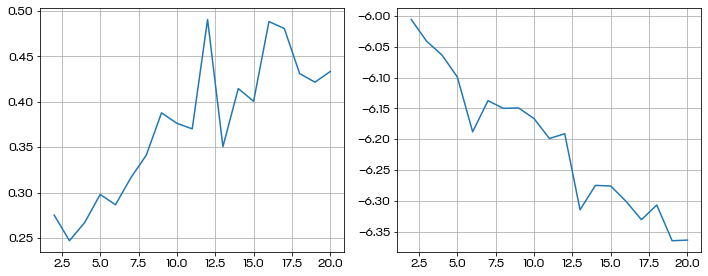

In [ ]:
x, y, z = zip(*score)
# fig, axes = plt.subplots(1,2)
plt.figure(figsize=(10,4), tight_layout=True)
plt.subplot(121)
plt.plot(x, y, label='coherence score')
plt.grid(True)
plt.subplot(122)
plt.plot(x, z, label='perplexity')
plt.grid(True)
plt.show()

### Topic Modeling

In [ ]:
num_topics = 4
chunksize = 100 # size of the doc looked at every pass
passes = 20 # number of passes through documents #10
iterations = 100
eval_every = 1 # Don't evaluate model perplexity, takes too much time

# Make a index to word dictionary.
temp = dictionary[0] # This is only to "load" the dictionary
id2word = dictionary.id2token

%time model = gensim.models.LdaModel(corpus=gensim_corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

In [ ]:
pprint(model.print_topics(num_words=15))
doc_lda = model[gensim_corpus]

# Compute Perplexity
print('\nPerplexity: ', model.log_perplexity(gensim_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=model, texts=df['trigram_mod'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

[(0,
  '0.020*"เนื้อ" + 0.019*"อร่อย" + 0.017*"น้ำ_ซุป" + 0.015*"รสชาติ" + '
  '0.015*"ราคา" + 0.012*"บริการ" + 0.010*"คุณภาพ" + 0.009*"สาขา" + '
  '0.009*"shabushi" + 0.009*"นั่ง" + 0.009*"icecream" + 0.008*"หม้อ" + '
  '0.008*"คุ้ม" + 0.007*"เมนู" + 0.007*"น้ำจิ้ม"'),
 (1,
  '0.016*"ราคา" + 0.015*"กุ้ง" + 0.015*"สด" + 0.012*"เนื้อ" + 0.012*"อร่อย" + '
  '0.012*"หวาน" + 0.011*"น้ำ_ซุป" + 0.011*"รสชาติ" + 0.011*"สาขา" + '
  '0.011*"shabushi" + 0.011*"คุ้ม" + 0.010*"เวลา" + 0.009*"บุฟเฟ่ต์" + '
  '0.009*"เมนู" + 0.007*"คุณภาพ"'),
 (2,
  '0.021*"อร่อย" + 0.019*"ราคา" + 0.017*"รสชาติ" + 0.015*"น้ำ_ซุป" + '
  '0.015*"บุฟเฟ่ต์" + 0.015*"สาขา" + 0.012*"pizza" + 0.010*"สด" + '
  '0.009*"บริการ" + 0.009*"เนื้อ" + 0.008*"หวาน" + 0.008*"พนักงาน" + '
  '0.008*"น้ำ" + 0.007*"คุณภาพ" + 0.007*"สั่ง"'),
 (3,
  '0.017*"ราคา" + 0.015*"น้ำ_ซุป" + 0.015*"รสชาติ" + 0.014*"เนื้อ" + '
  '0.012*"อร่อย" + 0.012*"สาขา" + 0.011*"shabushi" + 0.010*"บุฟเฟ่ต์" + '
  '0.009*"คุ้ม" + 0.009*"ชาบู" + 0.009*"เมนู" + 0.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
pyLDAvis.gensim_models.prepare(model, gensim_corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.045441  0.010195       1        1  31.168258
0      0.027880  0.033876       2        1  30.765052
1      0.011627 -0.038587       3        1  20.215686
3      0.005933 -0.005485       4        1  17.851004, topic_info=         Term      Freq     Total Category  logprob  loglift
246      กุ้ง  5.000000  5.000000  Default  30.0000  30.0000
341      เวลา  3.000000  3.000000  Default  29.0000  29.0000
432     pizza  4.000000  4.000000  Default  28.0000  28.0000
243  shabushi  8.000000  8.000000  Default  27.0000  27.0000
304       ปอก  2.000000  2.000000  Default  26.0000  26.0000
..        ...       ...       ...      ...      ...      ...
89        น้ำ  1.034890  6.059252   Topic4  -5.1250  -0.0442
46       นั่ง  0.968256  5.727543   Topic4  -5.1916  -0.0544
246      กุ้ง  0.945944  5.786649   Topic4  -5.2149  -0.0880
255       ทอด  0.903281  4.442268   Topic4  -5.2610   0.1302
109      หวาน  0.863872  7.320499   Topic4  -5.3057  -0.4139

[269 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.277121  icecream
0         2  0.415681  icecream
0         3  0.138560  icecream
0         4  0.138560  icecream
469       1  0.933604      mall
...     ...       ...       ...
130       3  0.206887       ไก่
130       4  0.206887       ไก่
132       2  0.510310    ไดฟูกุ
133       2  0.514383       ไผ่
134       2  0.515462       ไม้

[284 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4])

In [ ]:
result = []
topn = 15

for n in range(num_topics):
    temp_df = pd.DataFrame(model.get_topic_terms(n, topn=topn), columns=['word_id','prob'])
    temp_df['topic'] = n
    result.append(temp_df)

topic_terms_df = pd.concat(result)
topic_terms_df['word'] = topic_terms_df['word_id'].apply(lambda x: dictionary.get(x))
topic_terms_df.head()

,word_id,prob,topic,word
0,30,0.020393,0,เนื้อ
1,25,0.018522,0,อร่อย
2,10,0.016745,0,น้ำ_ซุป
3,15,0.015243,0,รสชาติ
4,17,0.015070,0,ราคา


In [ ]:
topic_terms_df['word'].unique()

array(['เนื้อ', 'อร่อย', 'น้ำ_ซุป', 'รสชาติ', 'ราคา', 'บริการ', 'คุณภาพ',
       'สาขา', 'shabushi', 'นั่ง', 'icecream', 'หม้อ', 'คุ้ม', 'เมนู',
       'น้ำจิ้ม', 'กุ้ง', 'สด', 'หวาน', 'เวลา', 'บุฟเฟ่ต์', 'pizza',
       'พนักงาน', 'น้ำ', 'สั่ง', 'ชาบู', 'ผัก'], dtype=object)

In [ ]:
topic_terms_df.to_pickle('topic_term.pkl')

In [ ]:
df['topic'] = df['trigram_mod'].apply(lambda x: model.get_document_topics(dictionary.doc2bow(x))[0][0])
df['score'] = df['trigram_mod'].apply(lambda x: model.get_document_topics(dictionary.doc2bow(x))[0][1])

In [ ]:
df[['Restaurant','cleansed_text','topic','score']]

,Restaurant,cleansed_text,topic,score
0,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,ที่สำคัญของร้านนี้คือบริการดีมากพนักงานน่ารักส...,0,0.998089
1,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,รสชาติเหมือนทุกสาขา แต่สาขานี้ บริการดี ที่นั่...,2,0.997896
2,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,ชาบูพรีเมียมสไตล์ญี่ปุ่น เนื้อดีมากก มาทานช่วง...,0,0.999106
3,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,เนื้อดี icecreamดี คุ้มค่าดี ถ้านึกถึงชาบูที่ม...,0,0.995860
4,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,อาหารมีคุณภาพ บริการดีค่ะ เดินมาหน้าร้านแล้วได...,0,0.996712
5,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,กินให้อิ่ม ที่ momo ร้านบุฟเฟ่ ชาบูแนวญี่ปุ่น ...,2,0.996688
6,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,ชาบู สุกกี้สไลด์ญี่ปุ่นที่แท้ทรู number ...,3,0.997838
7,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,ร้านชาบูแฟรนไชส์ ที่ราคาเหมาะสมกับคุณภาพ ถือว่...,3,0.997642
8,Shabushi (ชาบูชิ) เดอะมอลล์บางกะปิ ชั้น G,อร่อยคุ้ม ของทานเล่นเยอะมาก มา านที่ขาบูชิต้อง...,1,0.995538
9,Shabushi (ชาบูชิ) เดอะมอลล์บางกะปิ ชั้น G,ทานอีก ชอบกุ้งทอดเทมปุระ ใครชอบกุ้งทอดเทมปุระ ...,3,0.997271


In [ ]:
df.to_pickle('result.pkl')

## **Result**

In [ ]:
df = pd.read_pickle('result.pkl')
topic_terms_df = pd.read_pickle('topic_term.pkl')

In [ ]:
topic_terms_df.word.unique()

array(['เนื้อ', 'อร่อย', 'น้ำ_ซุป', 'รสชาติ', 'ราคา', 'บริการ', 'คุณภาพ',
       'สาขา', 'shabushi', 'นั่ง', 'icecream', 'หม้อ', 'คุ้ม', 'เมนู',
       'น้ำจิ้ม', 'กุ้ง', 'สด', 'หวาน', 'เวลา', 'บุฟเฟ่ต์', 'pizza',
       'พนักงาน', 'น้ำ', 'สั่ง', 'ชาบู', 'ผัก'], dtype=object)

In [ ]:
ttdf = topic_terms_df.sort_values(['topic','prob'],ascending=[True, False]).groupby('topic').head(10)
ttdf['word'].unique()

array(['เนื้อ', 'อร่อย', 'น้ำ_ซุป', 'รสชาติ', 'ราคา', 'บริการ', 'คุณภาพ',
       'สาขา', 'shabushi', 'นั่ง', 'กุ้ง', 'สด', 'หวาน', 'บุฟเฟ่ต์',
       'pizza', 'คุ้ม', 'ชาบู'], dtype=object)

### Restaurants x Topics

In [ ]:
pd.crosstab(df['Restaurant'], df['topic'])

topic,0,1,2,3
Restaurant,,,,
Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,4,0,2,2
Shabushi (ชาบูชิ) เดอะมอลล์บางกะปิ ชั้น G,2,3,1,2
ข้าน้อยขอชาบู,0,0,5,0


### Rating by Topic

In [ ]:
df.groupby('topic')['Rating'].describe()

,count,mean,std,min,25%,50%,75%,max
topic,,,,,,,,
0,6.0,4.333333,0.516398,4.0,4.0,4.0,4.75,5.0
1,3.0,3.333333,0.577350,3.0,3.0,3.0,3.50,4.0
2,7.0,4.142857,0.690066,3.0,4.0,4.0,4.50,5.0
3,4.0,3.500000,0.577350,3.0,3.0,3.5,4.00,4.0


In [ ]:
import networkx as nx
G = nx.Graph()

G.add_weighted_edges_from([(f"Topic {r['topic']}", r['word'], round(r['prob'],4)) for i,r in ttdf.iterrows()])

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 21
Number of edges: 40
Average degree:   3.8095


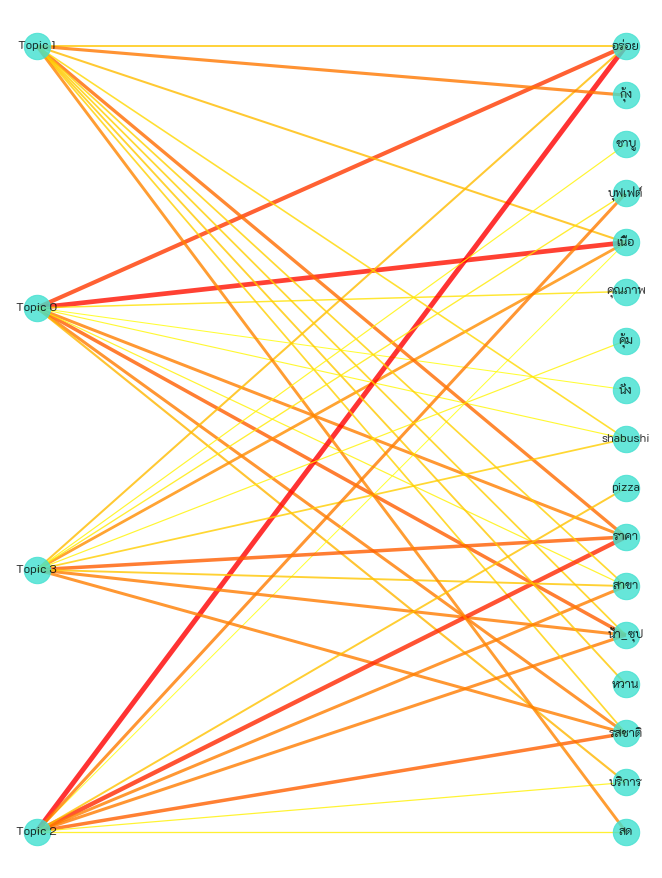

In [ ]:
# nodelist, node_size = zip(*[(n,d['support']) for n,d in G.nodes(data=True)])
# node_size = 150 + ((np.array(node_size) - min(node_size)) / (max(node_size) - min(node_size)))*1200
topic_nodes = [ f"Topic {i}" for i in range(num_topics)]
edgelist, weights = zip(*[((u,v), d['weight']) for u,v,d in G.edges(data=True)])


width = 1 + ((np.array(weights) - min(weights)) / (max(weights) - min(weights)))*4

labels_params = {'font_family': 'K2D', 'alpha':.8, 'font_size':12}

plt.figure(figsize=(9,12))

# pos = nx.spring_layout(G, k=5, weight='lift', iterations=120, seed=120, scale=2.5)
# pos = nx.spring_layout(G, k=5, weight='weight', iterations=80, seed=90, scale=2.5)
pos = nx.bipartite_layout(G, topic_nodes)
nx.draw(G, pos, with_labels=True, 
        edgelist=edgelist, width=width, edge_color=width, edge_cmap=plt.cm.autumn_r, #edge_color='.75',
        node_color='turquoise', node_size=700, 
        **labels_params)
# edge_labels = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='tomato',  **labels_params)

# plt.title('Association Rules of 1-itemsets')
# plt.savefig('plots/association-rules-1.jpg', dpi=120)
plt.show()